### dset check 
(note: the dataset is introduced and prepared in glacier-mapping repo:    
https://github.com/Hydrological-Observation-Group/glacier-mapping.git)
1. check pair-wise image and truth 
2. check the distribution of the dset. 

In [1]:
import numpy as np
from glob import glob
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
from notebooks import config 
import matplotlib.pyplot as plt
from pyrsimg import imsShow
import cartopy.feature as cfeature
from utils.transform_xy import coor2coor


In [2]:
names_satellite = [path_truth.split('/')[-1][0:2] 
                          for path_truth in config.paths_truth] 
print('Number of scenes:', len(config.paths_scene)) 
print('Satellite:', names_satellite[0])  


Number of scenes: 65
Satellite: l5


#### 1. Check the pair-wise sence and truth images


data/dset/scene/scene_nor/l8_scene_05.tif


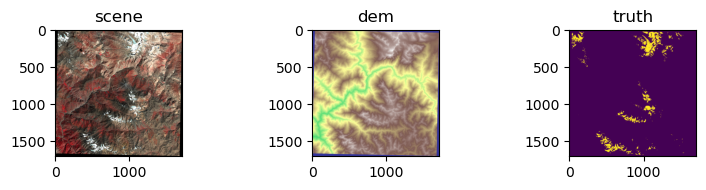

data/dset/scene/scene_nor/l8_scene_06.tif


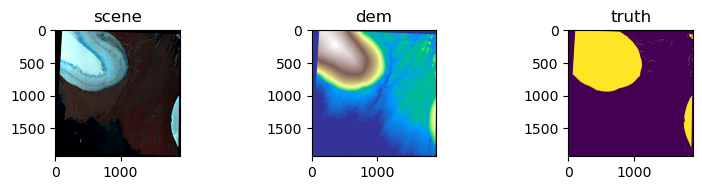

In [3]:
dset = list(zip(config.paths_scene, config.paths_truth, config.paths_dem))
for path_scene, path_truth, path_dem in dset[30:32]:
        print(path_scene)
        scene_rio = rio.open(path_scene)
        dem_rio = rio.open(path_dem)
        truth_rio = rio.open(path_truth)
        scene_truth_arr = [scene_rio.read([2,3,4]).transpose(1,2,0), 
                           dem_rio.read(1), truth_rio.read(1)]
        ax = imsShow(img_list=scene_truth_arr,
                img_name_list=['scene', 'dem', 'truth'], 
                clip_list=[2,0,0],
                figsize=(8,2))
        ax[1].imshow(dem_rio.read(1), cmap='terrain')
        plt.tight_layout() 
        plt.show()


#### check the distribution of dataset

In [4]:
paths_truth_tra_vec = [path.replace('tif', 'gpkg') for path in config.paths_truth_tra]
paths_truth_val_vec = [path.replace('tif', 'gpkg') for path in config.paths_truth_val] 
paths_truth_vec = paths_truth_tra_vec + paths_truth_val_vec


In [5]:
def get_center(path_vec):
    truth_vec_gpd = gpd.read_file(path_vec)
    truth_vec_gpd_wgs84 = truth_vec_gpd.to_crs(epsg=4326, inplace=False) 
    x_min, y_min, x_max, y_max = truth_vec_gpd_wgs84.union_all().bounds 
    center = ((x_min + x_max)/2, (y_min + y_max)/2) 
    return center
scene_centers = [get_center(path) for path in paths_truth_vec]


In [6]:
from shapely.geometry import Point
dset_gdf = gpd.GeoDataFrame({
    'scene_id': [path.split('/')[-1].split('.')[0] for path in paths_truth_vec],
    'satellite': [path.split('/')[-1][0:2] for path in paths_truth_vec],
    'tra': [path in paths_truth_tra_vec for path in paths_truth_vec],
    'geometry': [Point(center) for center in scene_centers],
    }, 
    crs='EPSG:4326')
# dset_gdf.to_file('data/dset/dset.gpkg', driver='GPKG') 
dset_gdf.head()


,scene_id,satellite,tra,geometry
0,l5_scene_02,l5,True,POINT (-26.10997 80.77131)
1,l5_scene_03,l5,True,POINT (-26.55014 81.76744)
2,l5_scene_04,l5,True,POINT (-17.9464 64.27999)
3,l5_scene_05,l5,True,POINT (-81.60499 74.72179)
4,l5_scene_07,l5,True,POINT (-70.74499 -54.51907)


In [7]:
sat_colors = {'l5': 'red', 
              'l7': 'green', 
              'l8': 'blue', 
              'l9': 'orange', 
              's2': 'purple'}


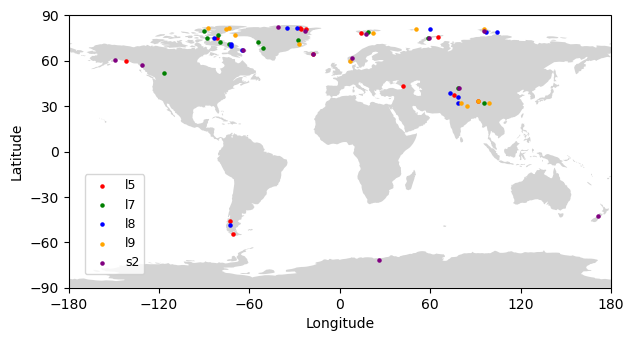

In [8]:
fig, ax = plt.subplots(figsize=(7, 5), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
for sat, color in sat_colors.items():
    dset_gdf[dset_gdf.scene_id.str[0:2] == sat].plot(
                    ax=ax, color=color, marker='o', markersize=5, label=sat)
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# # fig.savefig('figures/dset_distribution.png')


#### check the traset and valset

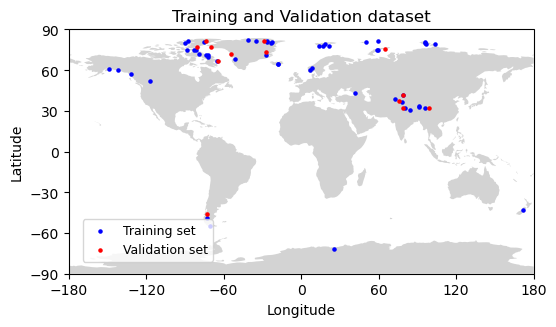

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), 
                subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
dset_gdf[dset_gdf.tra].plot(
                    ax=ax, 
                    color='blue', 
                    label='Training set',
                    markersize=5)
dset_gdf[~dset_gdf.tra].plot(
                    ax=ax, 
                    color='red', 
                    label='Validation set',
                    markersize=5)
ax.set_title('Training and Validation dataset')
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# fig.savefig('figs/traset_valset.png', dpi=300)

